In [1]:
import sys

sys.path.append("../")
from library.datasets import LungCancerDataset
from library.train import create_dataloader
from entrypoint import lung_scoring_function
import matplotlib.pyplot as plt
import torch
from library.models import *
import random
import glob
from icecream import ic
import copy
import pprint
import pandas as pd
from tqdm.auto import tqdm
import re

In [2]:
best_lung_models_combined = [
    i for i in glob.glob("../lung_training/**/*Model.pt", recursive=True)
]
best_lung_models_combined.extend(
    [i for i in glob.glob("../mega_lung_training/**/*Model.pt", recursive=True)]
)

In [3]:
best_lung_models_combined[-5:]

["../mega_lung_training/avg_fil_augmentation_event_loss_filter_True/LungCombinedResnet18PretrainedModel/2023-12-20_20-24-40/50_buckets_3_months/['layer2', 'layer3']/0.003_starting_lr/best_val_score_LungCombinedResnet18PretrainedModel.pt",
 "../mega_lung_training/avg_fil_augmentation_event_loss_filter_True/LungCombinedResnet18PretrainedModel/2023-12-29_11-18-04/100_buckets_1.5_months/['layer2', 'layer3']/0.05_starting_lr/best_val_acc_LungCombinedResnet18PretrainedModel.pt",
 "../mega_lung_training/avg_fil_augmentation_event_loss_filter_True/LungCombinedResnet18PretrainedModel/2023-12-29_11-18-04/100_buckets_1.5_months/['layer2', 'layer3']/0.05_starting_lr/best_val_score_LungCombinedResnet18PretrainedModel.pt",
 '../mega_lung_training/avg_fil_augmentation_event_loss_filter_True/LungCombinedResnet18PretrainedModel/2023-12-20_20-20-57/400_buckets_0.5_months/[]/0.05_starting_lr/best_val_acc_LungCombinedResnet18PretrainedModel.pt',
 '../mega_lung_training/avg_fil_augmentation_event_loss_filt

In [4]:
bucket_pattern = r".*/(.*\d)_buckets"
month_pattern = r".*/.*_buckets_(.*\d)_months"

In [5]:
def get_number_of_buckets(model_path):
    cur_match = re.match(bucket_pattern, model_path)
    return int(cur_match.group(1))


def get_number_of_months(model_path):
    cur_match = re.match(month_pattern, model_path)
    return float(cur_match.group(1))

In [6]:
best_lung_models_combined.sort(
    key=lambda x: (get_number_of_buckets(x), get_number_of_months(x))
)

In [7]:
best_lung_models_combined[-5:]

["../mega_lung_training/avg_fil_augmentation_event_loss_filter_True/LungCombinedResnet18PretrainedModel/2023-12-20_20-24-40/400_buckets_0.5_months/['layer2', 'layer3']/0.1_starting_lr/best_val_score_LungCombinedResnet18PretrainedModel.pt",
 "../mega_lung_training/avg_fil_augmentation_event_loss_filter_True/LungCombinedResnet18PretrainedModel/2023-12-20_20-24-40/400_buckets_0.5_months/['layer2', 'layer3']/0.003_starting_lr/best_val_acc_LungCombinedResnet18PretrainedModel.pt",
 "../mega_lung_training/avg_fil_augmentation_event_loss_filter_True/LungCombinedResnet18PretrainedModel/2023-12-20_20-24-40/400_buckets_0.5_months/['layer2', 'layer3']/0.003_starting_lr/best_val_score_LungCombinedResnet18PretrainedModel.pt",
 '../mega_lung_training/avg_fil_augmentation_event_loss_filter_True/LungCombinedResnet18PretrainedModel/2023-12-20_20-20-57/400_buckets_0.5_months/[]/0.05_starting_lr/best_val_acc_LungCombinedResnet18PretrainedModel.pt',
 '../mega_lung_training/avg_fil_augmentation_event_loss_f

In [8]:
lung_dir = "../datasets/train_lung/"
random_seed = 42024
number_of_buckets = 400
months_per_gt_bucket = 0.5

val_dataset = LungCancerDataset(
    lung_dir,
    split_type="val",
    random_seed=random_seed,
    number_of_buckets=number_of_buckets,
    months_per_gt_bucket=months_per_gt_bucket,
)
test_dataset = LungCancerDataset(
    lung_dir,
    split_type="test",
    random_seed=random_seed,
    number_of_buckets=number_of_buckets,
    months_per_gt_bucket=months_per_gt_bucket,
)

Adding raw case data to ChaimeleonDataset:   0%|          | 0/320 [00:00<?, ?it/s]

average image value:   0%|          | 0/320 [00:00<?, ?it/s]

Preparing val dataset:   0%|          | 0/48 [00:00<?, ?it/s]

Adding raw case data to ChaimeleonDataset:   0%|          | 0/320 [00:00<?, ?it/s]

average image value:   0%|          | 0/320 [00:00<?, ?it/s]

Preparing test dataset:   0%|          | 0/48 [00:00<?, ?it/s]

In [9]:
val_loader = create_dataloader(val_dataset, batch_size=6, shuffle=False)
test_loader = create_dataloader(test_dataset, batch_size=6, shuffle=False)

In [10]:
path_to_model = {
    "LungCombinedModel.pt": LungCombinedModel(number_of_buckets=number_of_buckets),
    "LungCombinedResnet18PretrainedModel.pt": LungCombinedResnet18PretrainedModel(
        number_of_buckets=number_of_buckets
    ),
}
test_path = "../lung_training/metadata_augmentation/LungCombinedResnet18PretrainedModel/2023-12-12_21-54-04/400_buckets_0.5_months/['layer2', 'layer3']/0.003_starting_lr/best_val_score_LungCombinedResnet18PretrainedModel.pt"
lung_model_base = path_to_model[test_path.split("_")[-1]]

In [11]:
# load model
model_state_dict = torch.load(test_path)
model = copy.deepcopy(lung_model_base)
model.load_state_dict(model_state_dict)
model = model.eval()

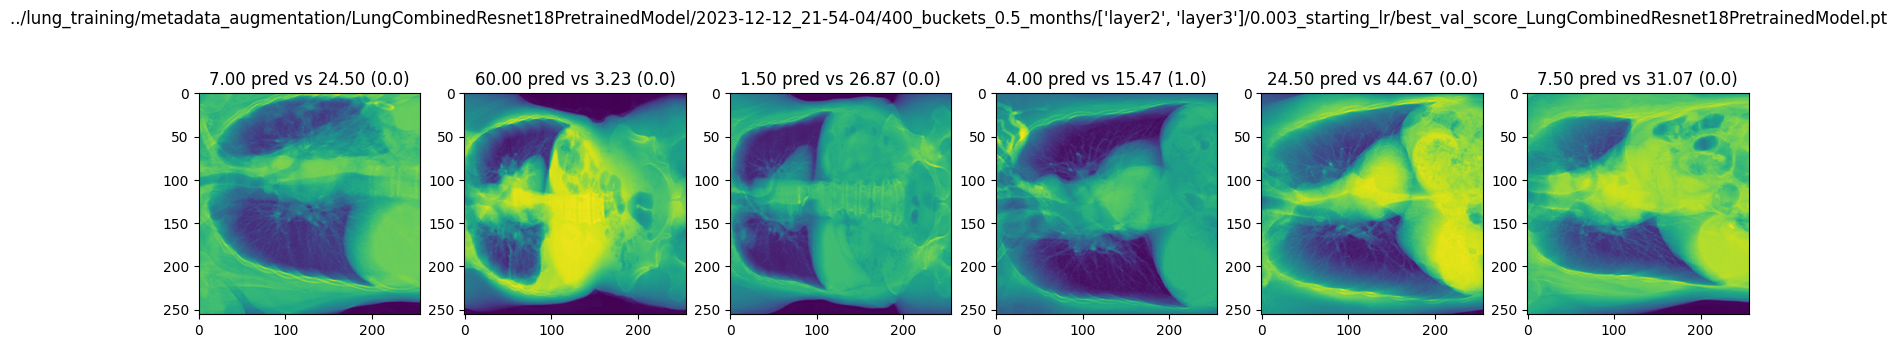

In [12]:
epoch_targets = []
epoch_preds = []
epoch_outputs = []
for batch_idx, (images, metadata, targets) in enumerate(val_loader):
    data = images, metadata.squeeze()
    if isinstance(targets, list):
        pfs = targets[1]
        targets = targets[0]
    else:
        targets = targets
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True)

    estimates = torch.nn.functional.softmax(output, dim=1)
    epoch_preds.extend([i.item() for i in pred])
    epoch_outputs.extend([i for i in estimates])
    epoch_targets.extend(pfs)
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(20, 4))
for ind in range(images.shape[0]):
    ax[ind].imshow(images[ind][4])
    ax[ind].set_title(
        f"{pred[ind].item()*months_per_gt_bucket:0.2f} pred vs {pfs[ind][1]:0.2f} ({pfs[ind][0]})"
    )
fig.suptitle(test_path)
score = lung_scoring_function(months_per_gt_bucket, epoch_targets, epoch_preds)

In [13]:
pprint.pprint(test_path)
pprint.pprint(score)

("../lung_training/metadata_augmentation/LungCombinedResnet18PretrainedModel/2023-12-12_21-54-04/400_buckets_0.5_months/['layer2', "
 "'layer3']/0.003_starting_lr/best_val_score_LungCombinedResnet18PretrainedModel.pt")
0.8037974683544303


In [14]:
del model
del val_loader
del test_loader
del val_dataset
del test_dataset

In [15]:
def load_saved_model(model_path, path_to_model):
    model_base = path_to_model[model_path.split("_")[-1]]
    model_state_dict = torch.load(model_path)
    model = copy.deepcopy(model_base)
    model.load_state_dict(model_state_dict)
    model = model.eval()

    return model

In [16]:
def evaluate_lung_model(
    eval_dataloader,
    model_path,
    path_to_model,
    verbose=False,
    visualize=False,
    eval_id=None,
):
    model = load_saved_model(model_path, path_to_model)

    epoch_targets = []
    epoch_preds = []
    epoch_outputs = []
    for batch_idx, (images, metadata, targets) in enumerate(eval_dataloader):
        data = images, metadata.squeeze()
        if isinstance(targets, list):
            pfs = targets[1]
            targets = targets[0]
        else:
            targets = targets
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)

        estimates = torch.nn.functional.softmax(output, dim=1)
        epoch_preds.extend([i.item() for i in pred])
        epoch_outputs.extend([i for i in estimates])
        epoch_targets.extend(pfs)

    score = lung_scoring_function(months_per_gt_bucket, epoch_targets, epoch_preds)
    if eval_id is not None:
        score_dict = {f"{eval_id}_c_index": score}
    else:
        score_dict = {"c_index": score}

    model_details = model_path.split("/")[2:]

    if verbose:
        pprint.pprint(model_details)
        pprint.pprint(score_dict)
        print("\n\n")

    if visualize and score > 0.78:
        fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(20, 5))
        for ind in range(images.shape[0]):
            ax[ind].imshow(images[ind][4])
            ax[ind].set_title(
                f"{pred[ind].item()*months_per_gt_bucket:0.2f} pred vs {pfs[ind][1]:0.2f} actual"
            )
        fig.suptitle(f"{model_path} - {score:0.4f}")
    return score_dict

  0%|          | 0/236 [00:00<?, ?it/s]

buckets: 0 -> 50 & months: 0 -> 3.0


Adding raw case data to ChaimeleonDataset:   0%|          | 0/320 [00:00<?, ?it/s]

average image value:   0%|          | 0/320 [00:00<?, ?it/s]

Preparing val dataset:   0%|          | 0/48 [00:00<?, ?it/s]

buckets: 50 -> 100 & months: 3.0 -> 1.5


Adding raw case data to ChaimeleonDataset:   0%|          | 0/320 [00:00<?, ?it/s]

average image value:   0%|          | 0/320 [00:00<?, ?it/s]

Preparing val dataset:   0%|          | 0/48 [00:00<?, ?it/s]

buckets: 100 -> 200 & months: 1.5 -> 0.75


Adding raw case data to ChaimeleonDataset:   0%|          | 0/320 [00:00<?, ?it/s]

average image value:   0%|          | 0/320 [00:00<?, ?it/s]

Preparing val dataset:   0%|          | 0/48 [00:00<?, ?it/s]

buckets: 200 -> 200 & months: 0.75 -> 1.0


Adding raw case data to ChaimeleonDataset:   0%|          | 0/320 [00:00<?, ?it/s]

average image value:   0%|          | 0/320 [00:00<?, ?it/s]

Preparing val dataset:   0%|          | 0/48 [00:00<?, ?it/s]

buckets: 200 -> 400 & months: 1.0 -> 0.5


Adding raw case data to ChaimeleonDataset:   0%|          | 0/320 [00:00<?, ?it/s]

average image value:   0%|          | 0/320 [00:00<?, ?it/s]

Preparing val dataset:   0%|          | 0/48 [00:00<?, ?it/s]

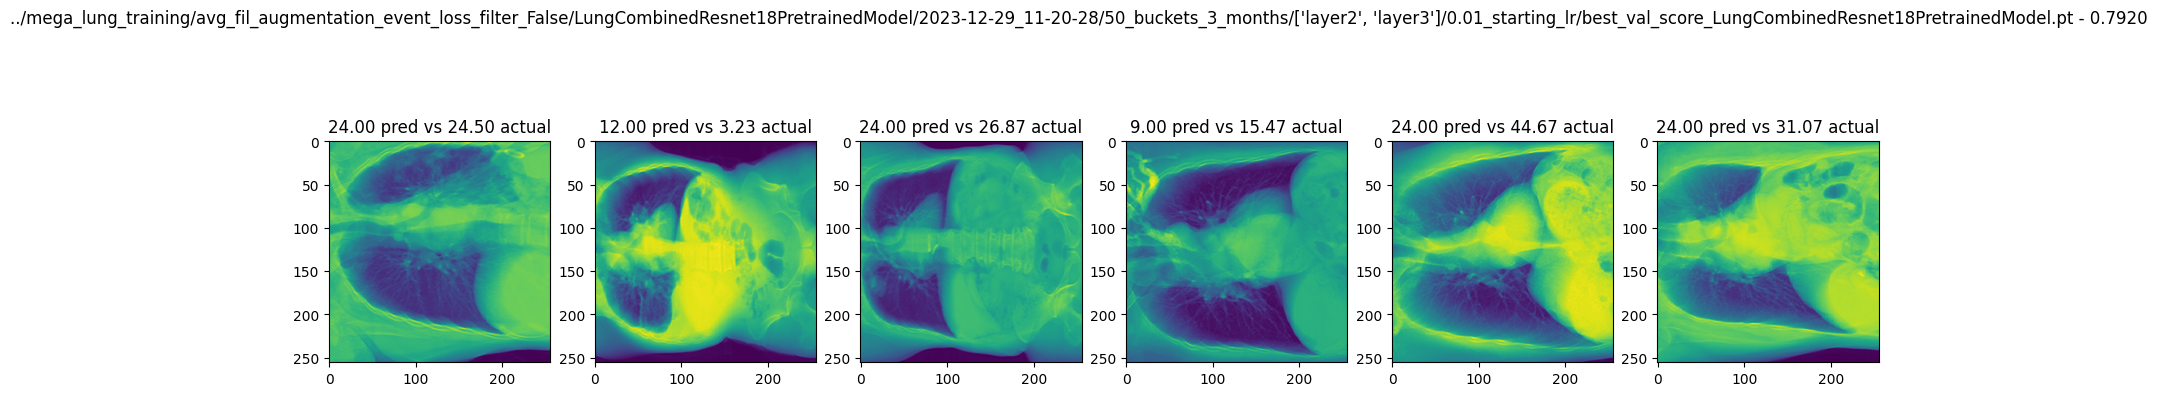

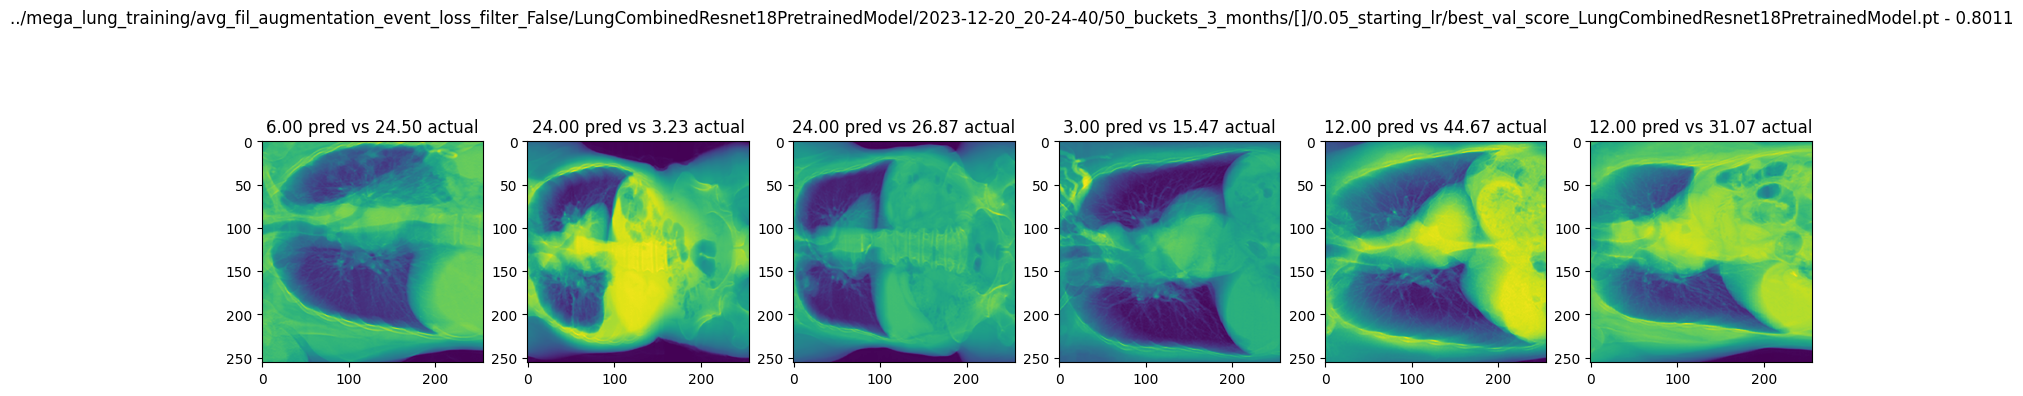

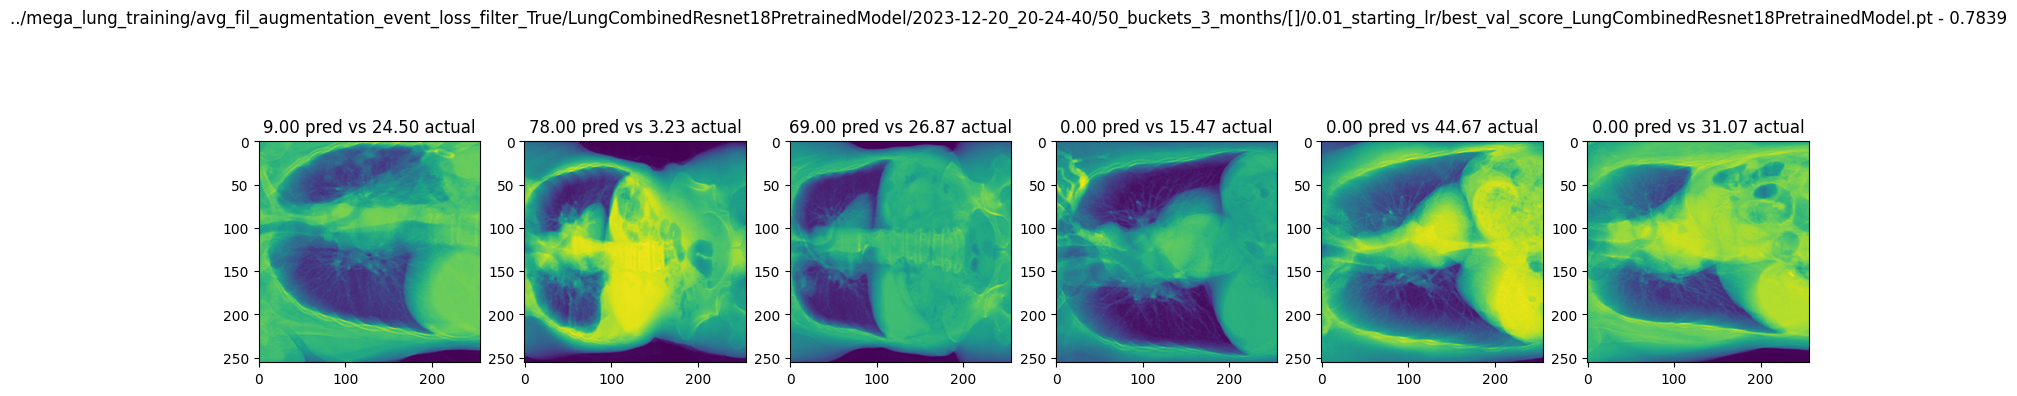

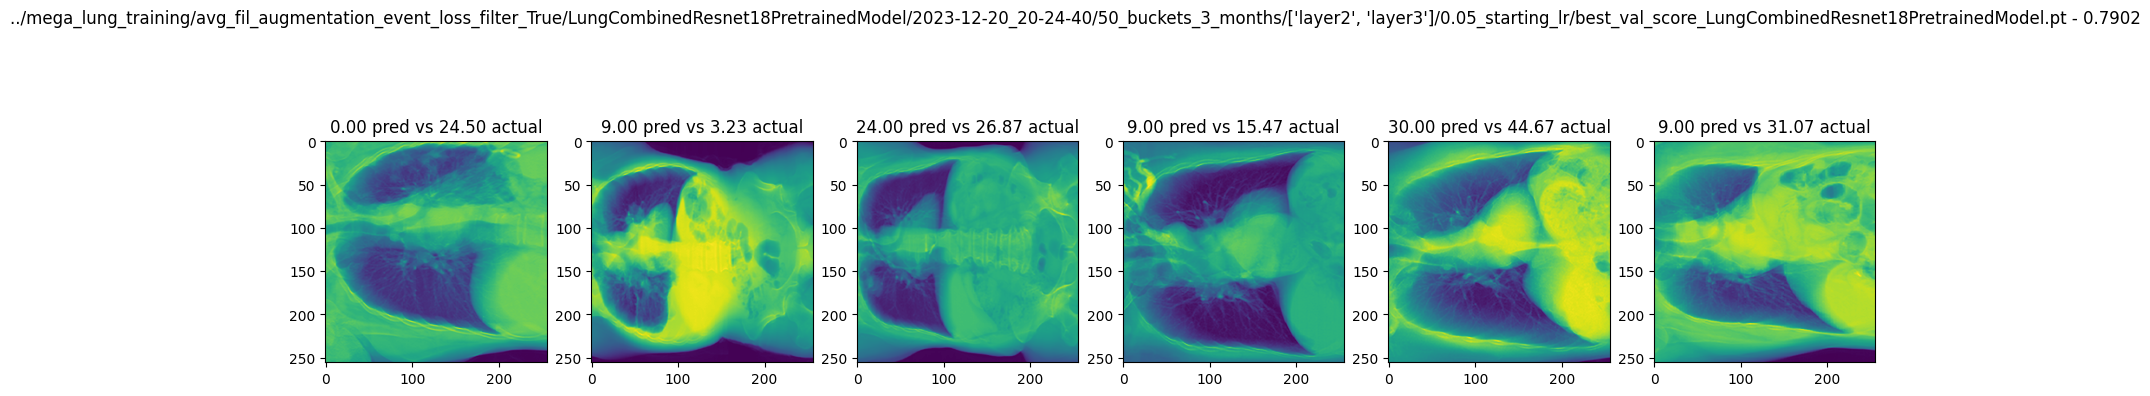

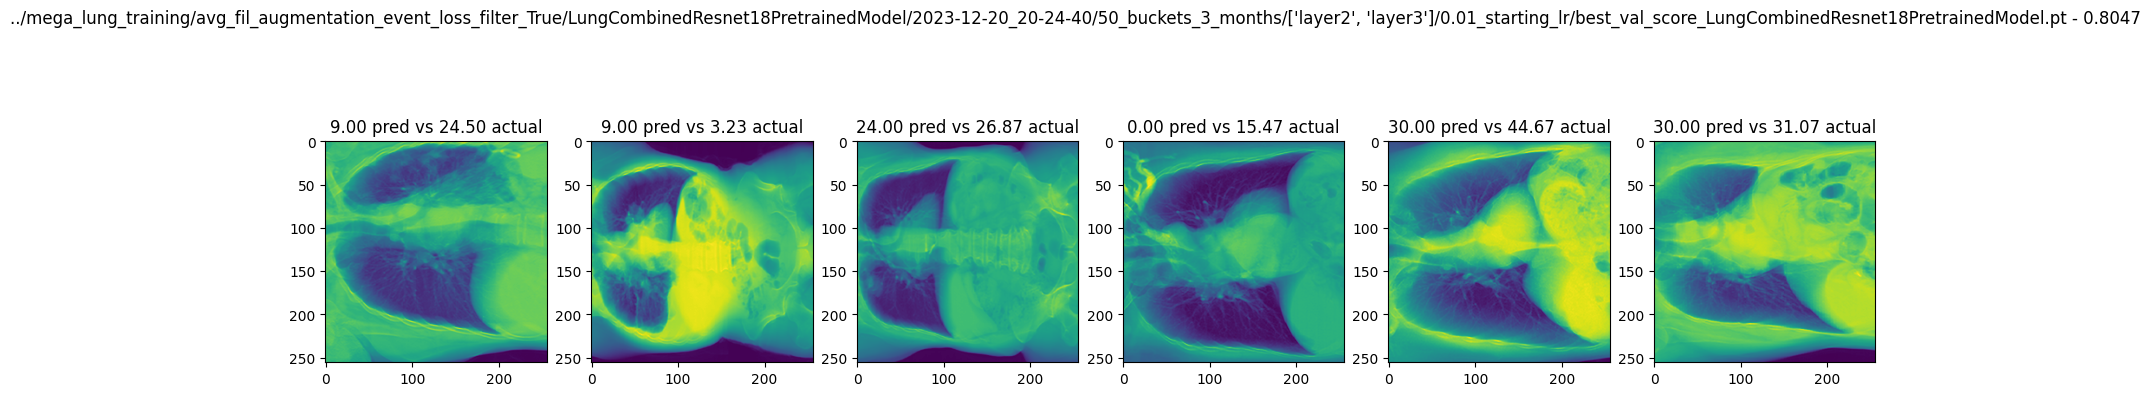

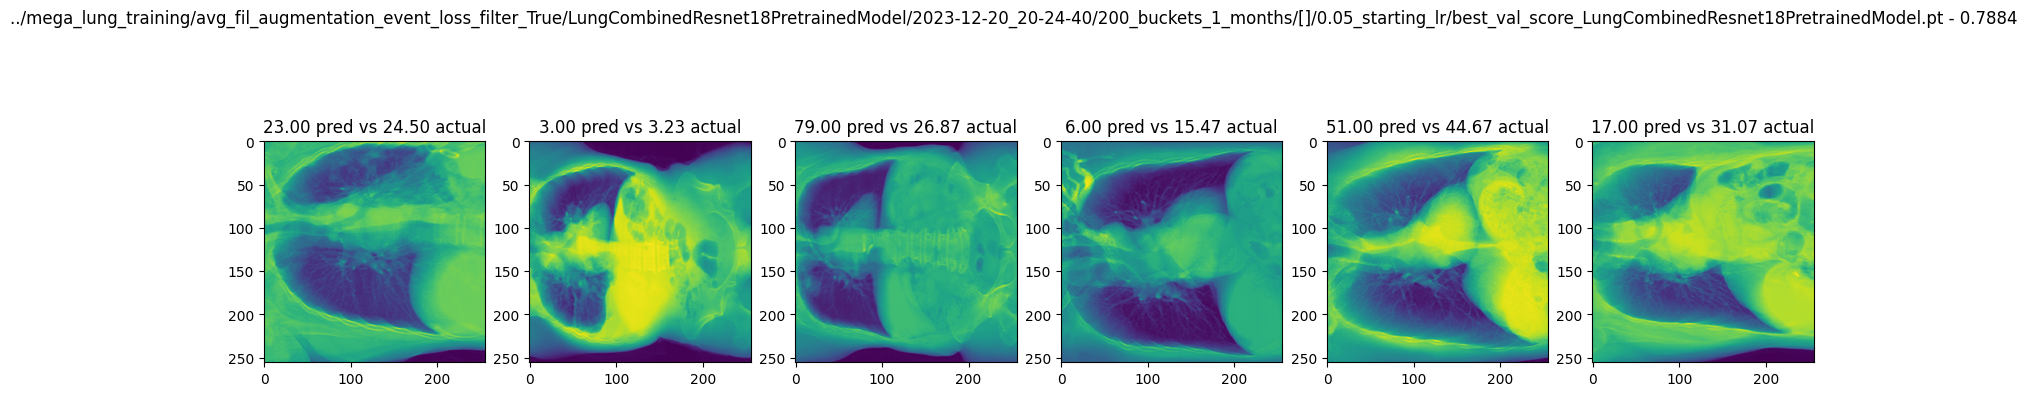

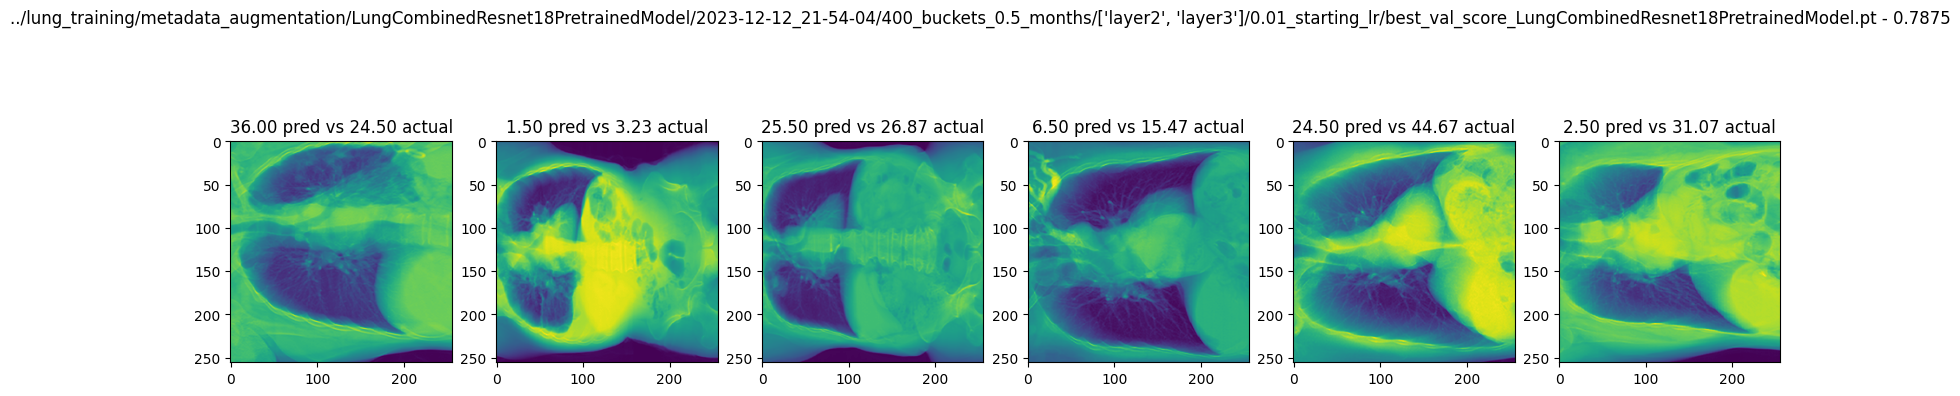

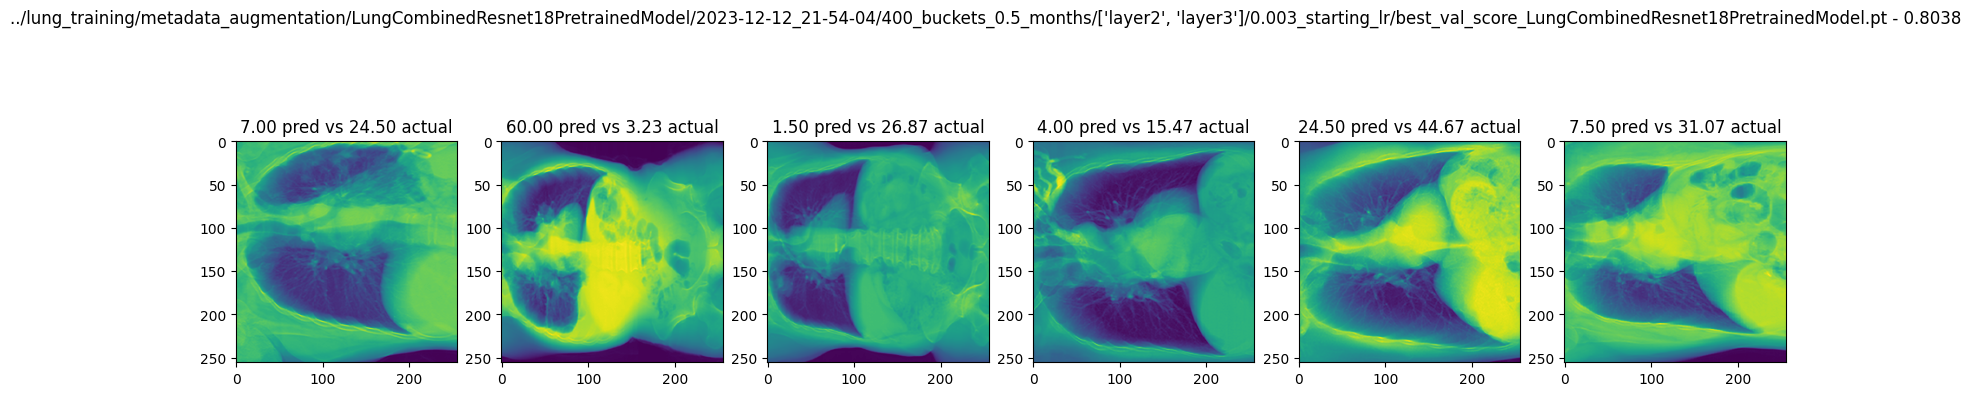

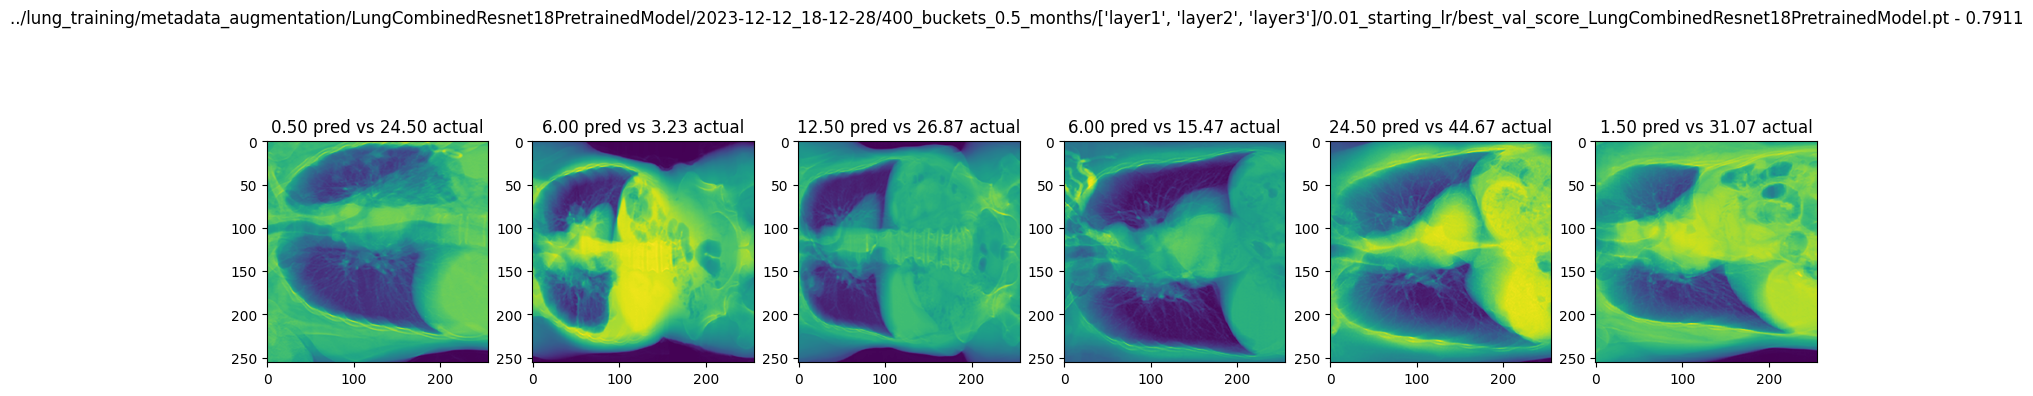

In [17]:
val_results = {}
current_buckets = 0
current_months = 0
for model_path in tqdm(best_lung_models_combined):
    number_of_buckets = get_number_of_buckets(model_path)
    months_per_gt_bucket = get_number_of_months(model_path)
    path_to_model = {
        "LungCombinedModel.pt": LungCombinedModel(number_of_buckets=number_of_buckets),
        "LungCombinedResnet18PretrainedModel.pt": LungCombinedResnet18PretrainedModel(
            number_of_buckets=number_of_buckets
        ),
    }
    if number_of_buckets != current_buckets or months_per_gt_bucket != current_months:
        print(
            f"buckets: {current_buckets} -> {number_of_buckets} & months: {current_months} -> {months_per_gt_bucket}"
        )
        val_dataset = LungCancerDataset(
            lung_dir,
            split_type="val",
            random_seed=random_seed,
            number_of_buckets=number_of_buckets,
            months_per_gt_bucket=months_per_gt_bucket,
        )
        val_loader = create_dataloader(val_dataset, batch_size=6, shuffle=False)
        current_buckets = number_of_buckets
        current_months = months_per_gt_bucket

    results = evaluate_lung_model(
        val_loader, model_path, path_to_model, eval_id="val", visualize=True
    )
    val_results[model_path] = results
    del results

In [18]:
test_results = {}
current_buckets = 0
current_months = 0
for model_path in tqdm(best_lung_models_combined):
    number_of_buckets = get_number_of_buckets(model_path)
    months_per_gt_bucket = get_number_of_months(model_path)
    path_to_model = {
        "LungCombinedModel.pt": LungCombinedModel(number_of_buckets=number_of_buckets),
        "LungCombinedResnet18PretrainedModel.pt": LungCombinedResnet18PretrainedModel(
            number_of_buckets=number_of_buckets
        ),
    }
    if number_of_buckets != current_buckets or months_per_gt_bucket != current_months:
        print(
            f"buckets: {current_buckets} -> {number_of_buckets} & months: {current_months} -> {months_per_gt_bucket}"
        )
        test_dataset = LungCancerDataset(
            lung_dir,
            split_type="test",
            random_seed=random_seed,
            number_of_buckets=number_of_buckets,
            months_per_gt_bucket=months_per_gt_bucket,
        )
        test_loader = create_dataloader(test_dataset, batch_size=6, shuffle=False)
        current_buckets = number_of_buckets
        current_months = months_per_gt_bucket

    results = evaluate_lung_model(
        test_loader, model_path, path_to_model, visualize=True, eval_id="test"
    )
    test_results[model_path] = results
    del results

  0%|          | 0/236 [00:00<?, ?it/s]

buckets: 0 -> 50 & months: 0 -> 3.0


Adding raw case data to ChaimeleonDataset:   0%|          | 0/320 [00:00<?, ?it/s]

average image value:   0%|          | 0/320 [00:00<?, ?it/s]

Preparing test dataset:   0%|          | 0/48 [00:00<?, ?it/s]

buckets: 50 -> 100 & months: 3.0 -> 1.5


Adding raw case data to ChaimeleonDataset:   0%|          | 0/320 [00:00<?, ?it/s]

average image value:   0%|          | 0/320 [00:00<?, ?it/s]

Preparing test dataset:   0%|          | 0/48 [00:00<?, ?it/s]

buckets: 100 -> 200 & months: 1.5 -> 0.75


Adding raw case data to ChaimeleonDataset:   0%|          | 0/320 [00:00<?, ?it/s]

average image value:   0%|          | 0/320 [00:00<?, ?it/s]

Preparing test dataset:   0%|          | 0/48 [00:00<?, ?it/s]

buckets: 200 -> 200 & months: 0.75 -> 1.0


Adding raw case data to ChaimeleonDataset:   0%|          | 0/320 [00:00<?, ?it/s]

average image value:   0%|          | 0/320 [00:00<?, ?it/s]

Preparing test dataset:   0%|          | 0/48 [00:00<?, ?it/s]

buckets: 200 -> 400 & months: 1.0 -> 0.5


Adding raw case data to ChaimeleonDataset:   0%|          | 0/320 [00:00<?, ?it/s]

average image value:   0%|          | 0/320 [00:00<?, ?it/s]

Preparing test dataset:   0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

buckets: 0 -> 50 & months: 0 -> 3.0


Adding raw case data to ChaimeleonDataset:   0%|          | 0/320 [00:00<?, ?it/s]

average image value:   0%|          | 0/320 [00:00<?, ?it/s]

Preparing test dataset:   0%|          | 0/48 [00:00<?, ?it/s]

buckets: 50 -> 100 & months: 3.0 -> 1.5


Adding raw case data to ChaimeleonDataset:   0%|          | 0/320 [00:00<?, ?it/s]

average image value:   0%|          | 0/320 [00:00<?, ?it/s]

Preparing test dataset:   0%|          | 0/48 [00:00<?, ?it/s]

buckets: 100 -> 200 & months: 1.5 -> 0.75


Adding raw case data to ChaimeleonDataset:   0%|          | 0/320 [00:00<?, ?it/s]

average image value:   0%|          | 0/320 [00:00<?, ?it/s]

Preparing test dataset:   0%|          | 0/48 [00:00<?, ?it/s]

buckets: 200 -> 200 & months: 0.75 -> 1.0


Adding raw case data to ChaimeleonDataset:   0%|          | 0/320 [00:00<?, ?it/s]

average image value:   0%|          | 0/320 [00:00<?, ?it/s]

Preparing test dataset:   0%|          | 0/48 [00:00<?, ?it/s]

buckets: 200 -> 400 & months: 1.0 -> 0.5


Adding raw case data to ChaimeleonDataset:   0%|          | 0/320 [00:00<?, ?it/s]

average image value:   0%|          | 0/320 [00:00<?, ?it/s]

Preparing test dataset:   0%|          | 0/48 [00:00<?, ?it/s]

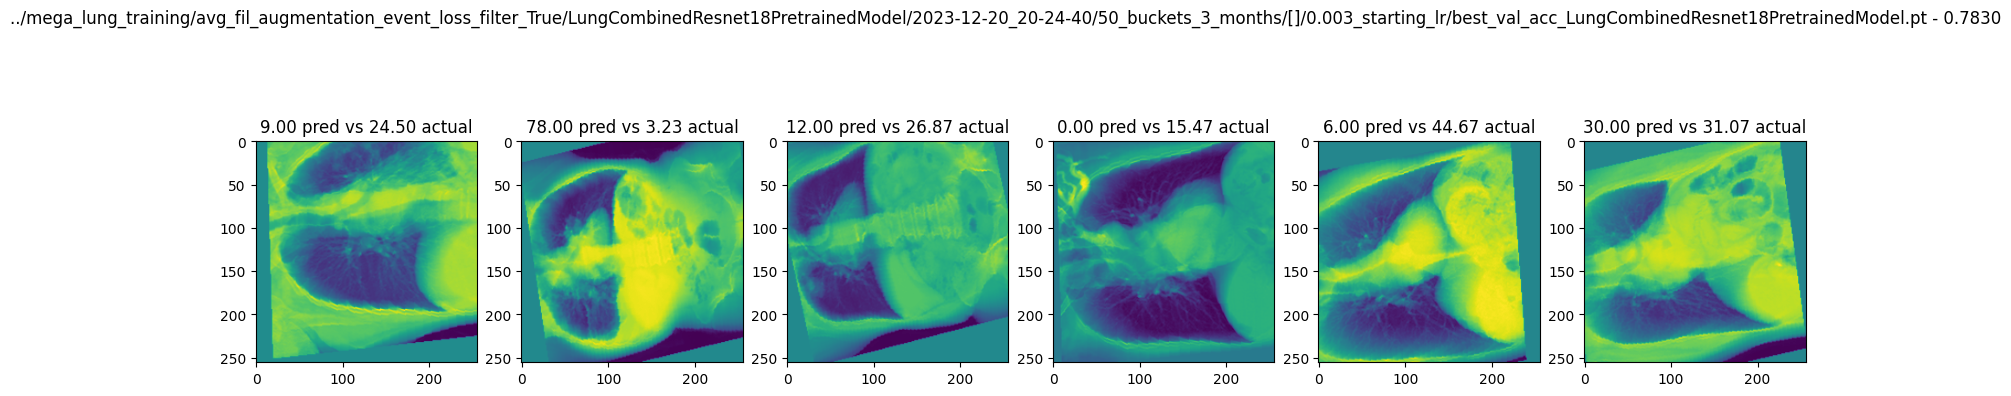

In [19]:
test_results_avg_fill = {}
current_buckets = 0
current_months = 0
for model_path in tqdm(best_lung_models_combined):
    number_of_buckets = get_number_of_buckets(model_path)
    months_per_gt_bucket = get_number_of_months(model_path)
    path_to_model = {
        "LungCombinedModel.pt": LungCombinedModel(number_of_buckets=number_of_buckets),
        "LungCombinedResnet18PretrainedModel.pt": LungCombinedResnet18PretrainedModel(
            number_of_buckets=number_of_buckets
        ),
    }
    if number_of_buckets != current_buckets or months_per_gt_bucket != current_months:
        print(
            f"buckets: {current_buckets} -> {number_of_buckets} & months: {current_months} -> {months_per_gt_bucket}"
        )
        test_dataset = LungCancerDataset(
            lung_dir,
            split_type="test",
            random_seed=random_seed,
            number_of_buckets=number_of_buckets,
            months_per_gt_bucket=months_per_gt_bucket,
            avg_fill=True,
        )
        test_loader = create_dataloader(test_dataset, batch_size=6, shuffle=False)
        current_buckets = number_of_buckets
        current_months = months_per_gt_bucket

    results = evaluate_lung_model(
        test_loader, model_path, path_to_model, visualize=True, eval_id="test_avg_fill"
    )
    test_results_avg_fill[model_path] = results
    del results

  0%|          | 0/236 [00:00<?, ?it/s]

buckets: 0 -> 50 & months: 0 -> 3.0


Adding raw case data to ChaimeleonDataset:   0%|          | 0/320 [00:00<?, ?it/s]

average image value:   0%|          | 0/320 [00:00<?, ?it/s]

Preparing test_extreme dataset:   0%|          | 0/48 [00:00<?, ?it/s]

buckets: 50 -> 100 & months: 3.0 -> 1.5


Adding raw case data to ChaimeleonDataset:   0%|          | 0/320 [00:00<?, ?it/s]

average image value:   0%|          | 0/320 [00:00<?, ?it/s]

Preparing test_extreme dataset:   0%|          | 0/48 [00:00<?, ?it/s]

buckets: 100 -> 200 & months: 1.5 -> 0.75


Adding raw case data to ChaimeleonDataset:   0%|          | 0/320 [00:00<?, ?it/s]

average image value:   0%|          | 0/320 [00:00<?, ?it/s]

Preparing test_extreme dataset:   0%|          | 0/48 [00:00<?, ?it/s]

buckets: 200 -> 200 & months: 0.75 -> 1.0


Adding raw case data to ChaimeleonDataset:   0%|          | 0/320 [00:00<?, ?it/s]

average image value:   0%|          | 0/320 [00:00<?, ?it/s]

Preparing test_extreme dataset:   0%|          | 0/48 [00:00<?, ?it/s]

buckets: 200 -> 400 & months: 1.0 -> 0.5


Adding raw case data to ChaimeleonDataset:   0%|          | 0/320 [00:00<?, ?it/s]

average image value:   0%|          | 0/320 [00:00<?, ?it/s]

Preparing test_extreme dataset:   0%|          | 0/48 [00:00<?, ?it/s]

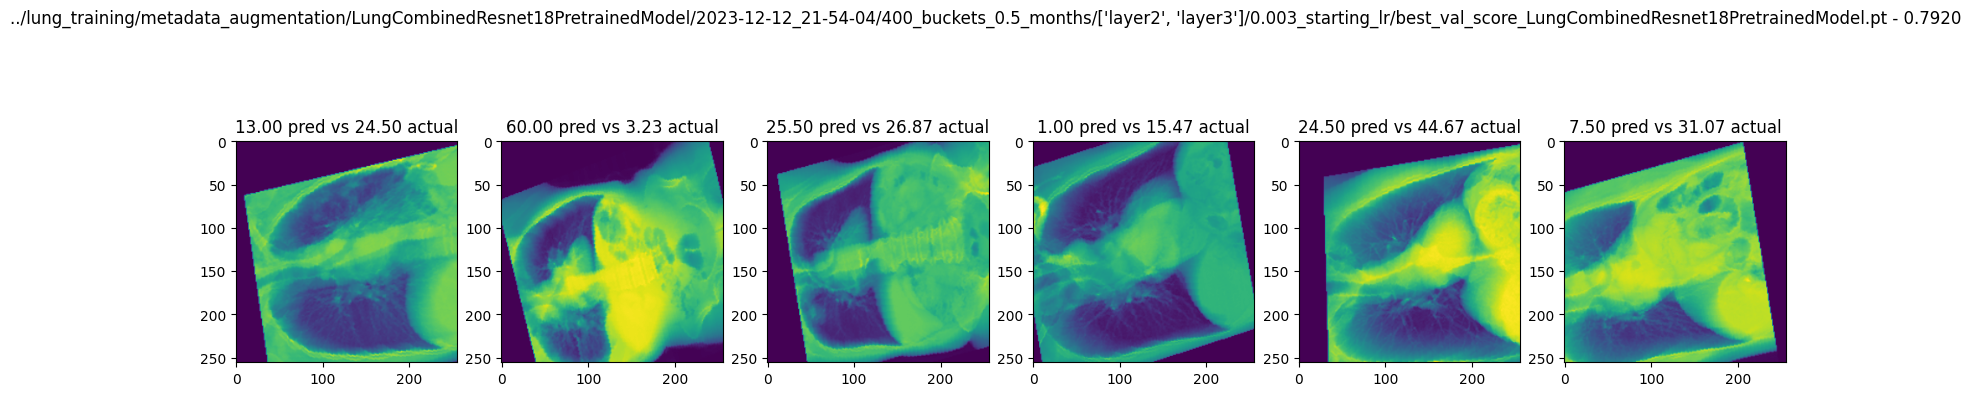

In [20]:
test_results_extreme = {}
current_buckets = 0
current_months = 0
for model_path in tqdm(best_lung_models_combined):
    number_of_buckets = get_number_of_buckets(model_path)
    months_per_gt_bucket = get_number_of_months(model_path)
    path_to_model = {
        "LungCombinedModel.pt": LungCombinedModel(number_of_buckets=number_of_buckets),
        "LungCombinedResnet18PretrainedModel.pt": LungCombinedResnet18PretrainedModel(
            number_of_buckets=number_of_buckets
        ),
    }
    if number_of_buckets != current_buckets or months_per_gt_bucket != current_months:
        print(
            f"buckets: {current_buckets} -> {number_of_buckets} & months: {current_months} -> {months_per_gt_bucket}"
        )
        test_dataset = LungCancerDataset(
            lung_dir,
            split_type="test_extreme",
            random_seed=random_seed,
            number_of_buckets=number_of_buckets,
            months_per_gt_bucket=months_per_gt_bucket,
        )
        test_loader = create_dataloader(test_dataset, batch_size=6, shuffle=False)
        current_buckets = number_of_buckets
        current_months = months_per_gt_bucket

    results = evaluate_lung_model(
        test_loader, model_path, path_to_model, visualize=True, eval_id="test_extreme"
    )
    test_results_extreme[model_path] = results
    del results

  0%|          | 0/236 [00:00<?, ?it/s]

buckets: 0 -> 50 & months: 0 -> 3.0


Adding raw case data to ChaimeleonDataset:   0%|          | 0/320 [00:00<?, ?it/s]

average image value:   0%|          | 0/320 [00:00<?, ?it/s]

Preparing test_extreme dataset:   0%|          | 0/48 [00:00<?, ?it/s]

buckets: 50 -> 100 & months: 3.0 -> 1.5


Adding raw case data to ChaimeleonDataset:   0%|          | 0/320 [00:00<?, ?it/s]

average image value:   0%|          | 0/320 [00:00<?, ?it/s]

Preparing test_extreme dataset:   0%|          | 0/48 [00:00<?, ?it/s]

buckets: 100 -> 200 & months: 1.5 -> 0.75


Adding raw case data to ChaimeleonDataset:   0%|          | 0/320 [00:00<?, ?it/s]

average image value:   0%|          | 0/320 [00:00<?, ?it/s]

Preparing test_extreme dataset:   0%|          | 0/48 [00:00<?, ?it/s]

buckets: 200 -> 200 & months: 0.75 -> 1.0


Adding raw case data to ChaimeleonDataset:   0%|          | 0/320 [00:00<?, ?it/s]

average image value:   0%|          | 0/320 [00:00<?, ?it/s]

Preparing test_extreme dataset:   0%|          | 0/48 [00:00<?, ?it/s]

buckets: 200 -> 400 & months: 1.0 -> 0.5


Adding raw case data to ChaimeleonDataset:   0%|          | 0/320 [00:00<?, ?it/s]

average image value:   0%|          | 0/320 [00:00<?, ?it/s]

Preparing test_extreme dataset:   0%|          | 0/48 [00:00<?, ?it/s]

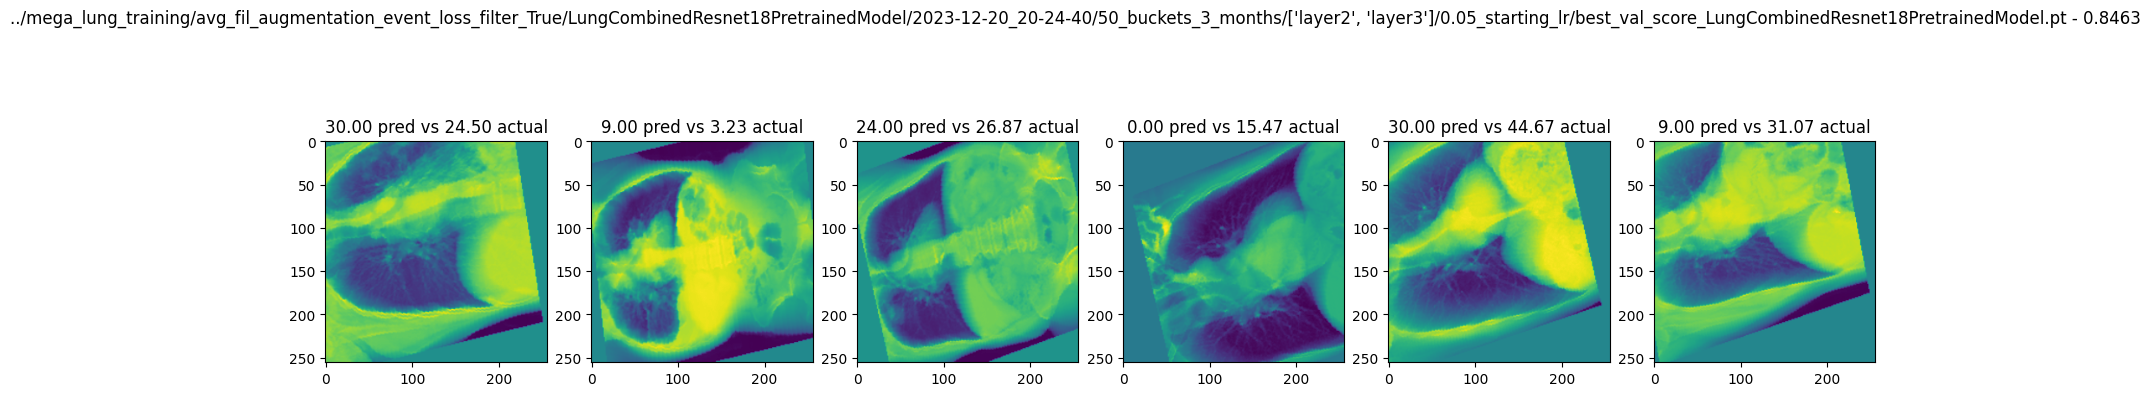

In [21]:
test_results_extreme_avg_fill = {}
current_buckets = 0
current_months = 0
for model_path in tqdm(best_lung_models_combined):
    number_of_buckets = get_number_of_buckets(model_path)
    months_per_gt_bucket = get_number_of_months(model_path)
    path_to_model = {
        "LungCombinedModel.pt": LungCombinedModel(number_of_buckets=number_of_buckets),
        "LungCombinedResnet18PretrainedModel.pt": LungCombinedResnet18PretrainedModel(
            number_of_buckets=number_of_buckets
        ),
    }
    if number_of_buckets != current_buckets or months_per_gt_bucket != current_months:
        print(
            f"buckets: {current_buckets} -> {number_of_buckets} & months: {current_months} -> {months_per_gt_bucket}"
        )
        test_dataset = LungCancerDataset(
            lung_dir,
            split_type="test_extreme",
            random_seed=random_seed,
            number_of_buckets=number_of_buckets,
            months_per_gt_bucket=months_per_gt_bucket,
            avg_fill=True,
        )
        test_loader = create_dataloader(test_dataset, batch_size=6, shuffle=False)
        current_buckets = number_of_buckets
        current_months = months_per_gt_bucket

    results = evaluate_lung_model(
        test_loader,
        model_path,
        path_to_model,
        visualize=True,
        eval_id="test_extreme_avg_fill",
    )
    test_results_extreme_avg_fill[model_path] = results
    del results

In [22]:
val_df = pd.DataFrame.from_dict(val_results, orient="index")
test_df = pd.DataFrame.from_dict(test_results, orient="index")
test_avg_fill_df = pd.DataFrame.from_dict(test_results_avg_fill, orient="index")
test_extreme_df = pd.DataFrame.from_dict(test_results_extreme, orient="index")
test_extreme_avg_fil_df = pd.DataFrame.from_dict(
    test_results_extreme_avg_fill, orient="index"
)

In [23]:
val_df

val_c_index
../lung_training/LungCombinedModel/2023-12-11_2...     0.691682
../lung_training/LungCombinedModel/2023-12-11_2...     0.603978
../lung_training/LungCombinedModel/2023-12-11_2...     0.626582
../lung_training/LungCombinedModel/2023-12-11_2...     0.500000
../lung_training/LungCombinedModel/2023-12-11_2...     0.721519
...                                                         ...
../mega_lung_training/limited_augmentation_incr...     0.698915
../mega_lung_training/limited_augmentation_incr...     0.565099
../mega_lung_training/limited_augmentation_incr...     0.717902
../mega_lung_training/limited_augmentation_incr...     0.500000
../mega_lung_training/limited_augmentation_incr...     0.688065

[236 rows x 1 columns]

In [24]:
test_extreme_avg_fil_df

test_extreme_avg_fill_c_index
../lung_training/LungCombinedModel/2023-12-11_2...                       0.537975
../lung_training/LungCombinedModel/2023-12-11_2...                       0.473779
../lung_training/LungCombinedModel/2023-12-11_2...                       0.481013
../lung_training/LungCombinedModel/2023-12-11_2...                       0.502712
../lung_training/LungCombinedModel/2023-12-11_2...                       0.446655
...                                                                           ...
../mega_lung_training/limited_augmentation_incr...                       0.654611
../mega_lung_training/limited_augmentation_incr...                       0.478300
../mega_lung_training/limited_augmentation_incr...                       0.616637
../mega_lung_training/limited_augmentation_incr...                       0.500000
../mega_lung_training/limited_augmentation_incr...                       0.570524

[236 rows x 1 columns]

In [25]:
results_df = pd.merge(val_df, test_df, left_index=True, right_index=True)
results_df = pd.merge(results_df, test_avg_fill_df, left_index=True, right_index=True)
results_df = pd.merge(results_df, test_extreme_df, left_index=True, right_index=True)
results_df = pd.merge(
    results_df, test_extreme_avg_fil_df, left_index=True, right_index=True
)

In [26]:
results_df.to_csv("./2023_01_06_lung_eval_results.csv")

In [27]:
results_df.to_excel(
    "./2023_01_06_lung_eval_results_mega_training_classification_phase_final_3.xlsx",
    sheet_name="eval_results",
)